# Dataset: 
https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification

In [1]:
import os

def display_contents(path, indent=0):
    for root, dirs, files in os.walk(path):
        current_indent = ' ' * indent
        print(f"{current_indent}{root}")
        
        for file in files[:3]:
            print(f"{current_indent}  File: {file}")
        if len(files) > 3:
            print(f"{current_indent}  ... [ total : {len(files)}]")
        
        for directory in dirs:
            display_contents(os.path.join(root, directory), indent + 2)

def n_images(path):
    counter = 0
    for root, dirs, files in os.walk(path):
        for file in files[:3]:
            counter+=1  
        for directory in dirs:
            counter+=n_images(os.path.join(root, directory))
    return counter

dataset_path = "..\dataset"
# display_contents(dataset_path) # in case you want to see what the folder looks like
print("N of files (images):",n_images(dataset_path))


N of files (images): 1382


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
import random

In [3]:
input_base_path = dataset_path # path for the dataset
training_folder = 'traffic_Data/DATA'
testing_folder = 'traffic_Data/TEST'
##classes = pd.read_csv(os.path.join(input_base_path,'labels.csv'))
new_labels = [(0,[0,1,2,3,4,5,6,7,18,19],"Speed Limit"),
          (1,[8,9,10,11,12,13,14,15,16,17,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,43,44,46,47,48,50,51,53,54,55],"Others"),
          (2,[40,41,42,45,49,52,56,57],"Unknown")]
classes = pd.DataFrame([{"ClassId": 0, "Name":"Speed Limit"},{"ClassId": 1, "Name":"Others"},{"ClassId": 2, "Name":"Unknown"}])
print("Total number of classes: ", len(classes))

Total number of classes:  3


In [4]:
from PIL import Image, ImageEnhance
import os

def augment_image(original_image: Image.Image):
    augmented = [original_image]
    for i in range(1, 5):
        augmented_image = original_image.copy()
        if i == 1:
            augmented_image = augmented_image.convert('RGB').quantize(colors=32)
        elif i == 2:
            enhancer = ImageEnhance.Brightness(augmented_image)
            augmented_image = enhancer.enhance(0.7)
        elif i == 3:
            augmented_image = augmented_image.rotate(25)
        elif i == 4:
            augmented_image = augmented_image.rotate(-25)
        augmented.append(augmented_image)
    return augmented

In [5]:
def convert_class_n(n_class):
    for label in new_labels:
        if n_class in label[1]:
            return label[0]

In [6]:
from tqdm import tqdm


traffic_data = []
training_data = []
labels = []
def fetch_images(traffic_data: list, labels: list, augment: bool = False) -> tuple[list, list]:
    for i, class_value in tqdm(enumerate(os.listdir(os.path.join(input_base_path, training_folder)))):
        class_path = os.path.join(input_base_path, training_folder, class_value)
        class_value = convert_class_n(i)
        labels.append(class_value)
        for trafficSignal in os.listdir(class_path):
            img = Image.open(os.path.join(class_path,trafficSignal))
            if augment:
                for img in augment_image(img):
                    img = img.resize((90,90))
                    img = np.array(img)
                    traffic_data.append((img,[convert_class_n(i)]))
            else:
                img = img.resize((90,90))
                img = np.array(img)
                traffic_data.append((img,[convert_class_n(i)]))
    labels = np.array(labels)
    return traffic_data, labels

In [7]:
traffic_data, labels = fetch_images(traffic_data, labels)

traffic_data_features, traffic_data_labels = zip(*traffic_data)
training_data_features, validation_data_features, training_data_labels, validation_data_labels = train_test_split(traffic_data_features, traffic_data_labels, test_size=0.33, random_state=42)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)
print(training_data_features.shape)
print(training_data_labels.shape)
print(traffic_data)

58it [00:13,  4.40it/s]


(2793, 90, 90, 3)
(2793, 1)
[(array([[[131, 114,  98],
        [131, 114,  97],
        [131, 114,  98],
        ...,
        [101,  87,  75],
        [102,  87,  76],
        [103,  89,  76]],

       [[133, 114,  99],
        [132, 114,  98],
        [133, 112,  98],
        ...,
        [103,  89,  76],
        [103,  89,  76],
        [102,  90,  77]],

       [[135, 113,  99],
        [134, 113,  99],
        [132, 112,  98],
        ...,
        [104,  90,  78],
        [104,  91,  78],
        [104,  90,  79]],

       ...,

       [[159,  51,  89],
        [161,  22,  62],
        [160,  56,  74],
        ...,
        [ 76,  75,  67],
        [ 89,  85,  76],
        [ 88,  83,  74]],

       [[155,  37,  74],
        [158,  22,  57],
        [158,  56,  73],
        ...,
        [ 73,  74,  63],
        [ 90,  85,  75],
        [ 90,  84,  74]],

       [[156,  24,  57],
        [159,  21,  57],
        [159,  59,  77],
        ...,
        [ 73,  72,  63],
        [ 92,  85, 

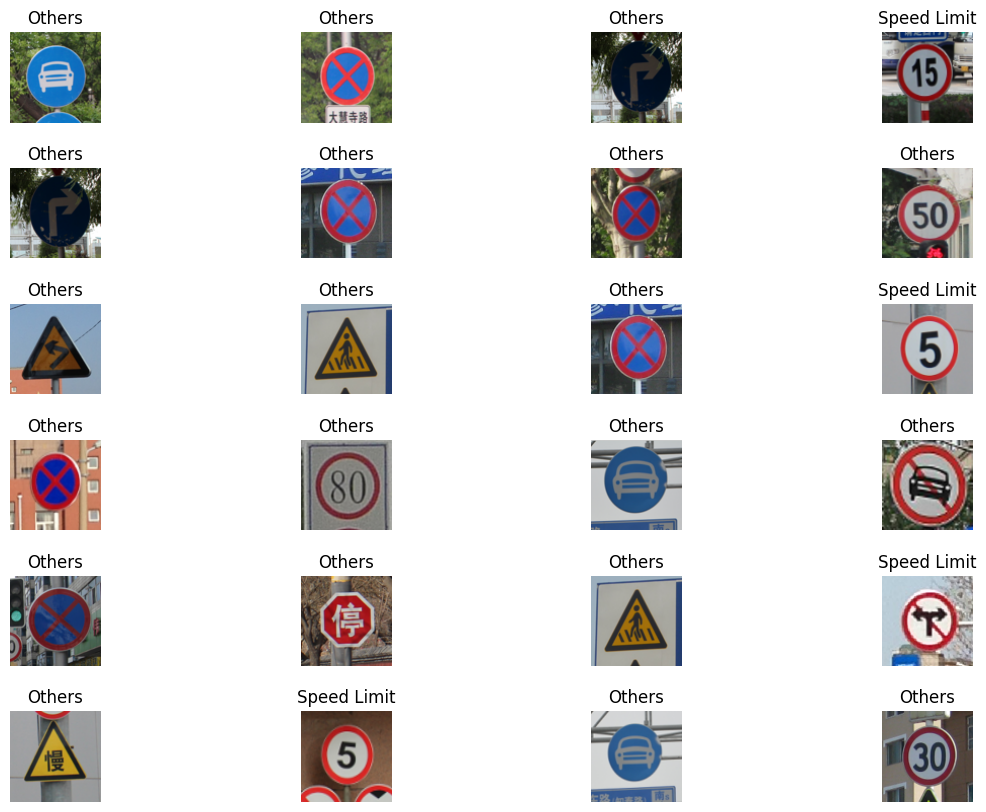

In [8]:
def img_displayer(data_features: list, data_labels_act: list, classes: list, data_labels_pred: list = None):
    rows, cols = 6, 4
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    plt.subplots_adjust(wspace = 0, hspace = 0.5) 
    if data_labels_pred is not None:
        for row in range(rows):
            for col in range(cols):
                i = row * cols + col
                random_val = random.randint(1,2)
                display_image = data_features[i*random_val]
                display_label_act = classes['Name'][data_labels_act[i*random_val][0]]
                display_label_pred = classes['Name'][data_labels_pred[i*random_val]]

                axes[row, col].imshow(display_image, cmap='gray') 
                axes[row, col].set_title((display_label_act, display_label_pred))
                axes[row, col].axis('off')
    else:
        for row in range(rows):
            for col in range(cols):
                i = row * cols + col
                random_val = random.randint(1,2)
                display_image = data_features[i*random_val]
                display_label = classes['Name'][data_labels_act[i*random_val][0]]

                axes[row, col].imshow(display_image, cmap='gray') 
                axes[row, col].set_title(display_label)
                axes[row, col].axis('off')
img_displayer(training_data_features, training_data_labels, classes)

In [9]:
def convolution_model() -> Sequential:
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, (3, 3), padding="same", input_shape=(90, 90, 3), activation='relu'))
    print(cnn_model(training_data_features).shape)
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Conv2D(64,(3,3), padding="same", activation='relu'))
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Conv2D(128,(5,5), padding="same", activation='relu'))
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Conv2D(128,(7,7), padding="same", activation='relu'))
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(192, activation='relu'))
    cnn_model.add(Dense(96, activation='relu'))
    cnn_model.add(Dense(48, activation='softmax'))
    return cnn_model

In [10]:
epochs = 6
batch_size = 400
cnn_model = convolution_model()
cnn_model.summary()


(2793, 90, 90, 32)


In [ ]:
print(training_data_features.shape, training_data_labels.shape)
print(training_data_labels)

(2793, 90, 90, 3) (2793, 1)
[[1]
 [1]
 [0]
 ...
 [2]
 [1]
 [1]]


In [ ]:
cnn_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
traffic_sign_network = cnn_model.fit(training_data_features, training_data_labels, batch_size=batch_size, epochs=epochs, validation_data=(validation_data_features, validation_data_labels))

Epoch 1/6


c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 26s 3s/step - loss: 21.5067 - accuracy: 0.5252 - val_loss: 1.4061 - val_accuracy: 0.7175
Epoch 2/6
7/7 [==============================] - 12s 2s/step - loss: 1.0963 - accuracy: 0.7290 - val_loss: 0.8140 - val_accuracy: 0.7168
Epoch 3/6
7/7 [==============================] - 15s 2s/step - loss: 0.7538 - accuracy: 0.7290 - val_loss: 0.6986 - val_accuracy: 0.7262
Epoch 4/6
7/7 [==============================] - 14s 2s/step - loss: 0.6038 - accuracy: 0.7744 - val_loss: 0.5341 - val_accuracy: 0.8126
Epoch 5/6
7/7 [==============================] - 14s 2s/step - loss: 0.5094 - accuracy: 0.8052 - val_loss: 0.5072 - val_accuracy: 0.8112
Epoch 6/6
7/7 [==============================] - 14s 2s/step - loss: 0.3932 - accuracy: 0.8639 - val_loss: 0.3667 - val_accuracy: 0.8656


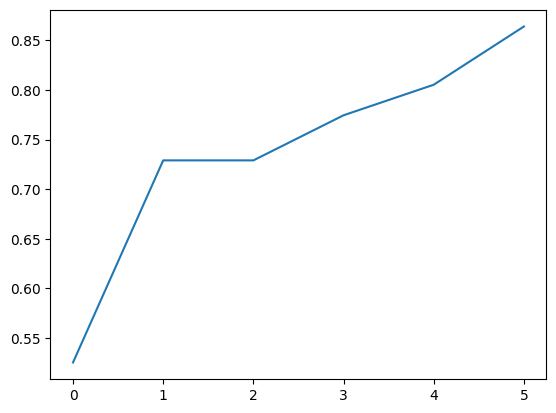

In [ ]:
plt.plot(traffic_sign_network.history['accuracy'], label='accuracy')

In [ ]:
testing_data = []
for test_image_file in os.listdir(os.path.join(input_base_path, testing_folder)):
    testImage = Image.open(os.path.join(input_base_path, testing_folder, test_image_file))
    testImage = testImage.resize((90,90))
    testImage = np.array(testImage)
    testing_data.append((testImage, [convert_class_n(int(test_image_file[1:3]))]))
testing_data_features, testing_data_labels = zip(*testing_data)
testing_data_features = np.array(testing_data_features)
testing_data_labels = np.array(testing_data_labels)

In [ ]:
predictions = cnn_model.predict(testing_data_features)
predicted_labels = np.argmax(predictions, axis=1)

63/63 [==============================] - 3s 49ms/step


1         Others
1         Others
1         Others
0    Speed Limit
0    Speed Limit
        ...     
1         Others
1         Others
1         Others
1         Others
1         Others
Name: Name, Length: 1994, dtype: object
0    Speed Limit
0    Speed Limit
0    Speed Limit
0    Speed Limit
0    Speed Limit
        ...     
2        Unknown
2        Unknown
2        Unknown
2        Unknown
2        Unknown
Name: Name, Length: 1994, dtype: object


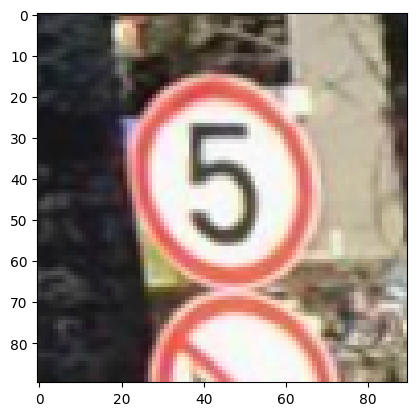

In [ ]:
print(classes['Name'][predicted_labels])
print(classes['Name'][testing_data_labels[:,0]])
plt.imshow(testing_data_features[1])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

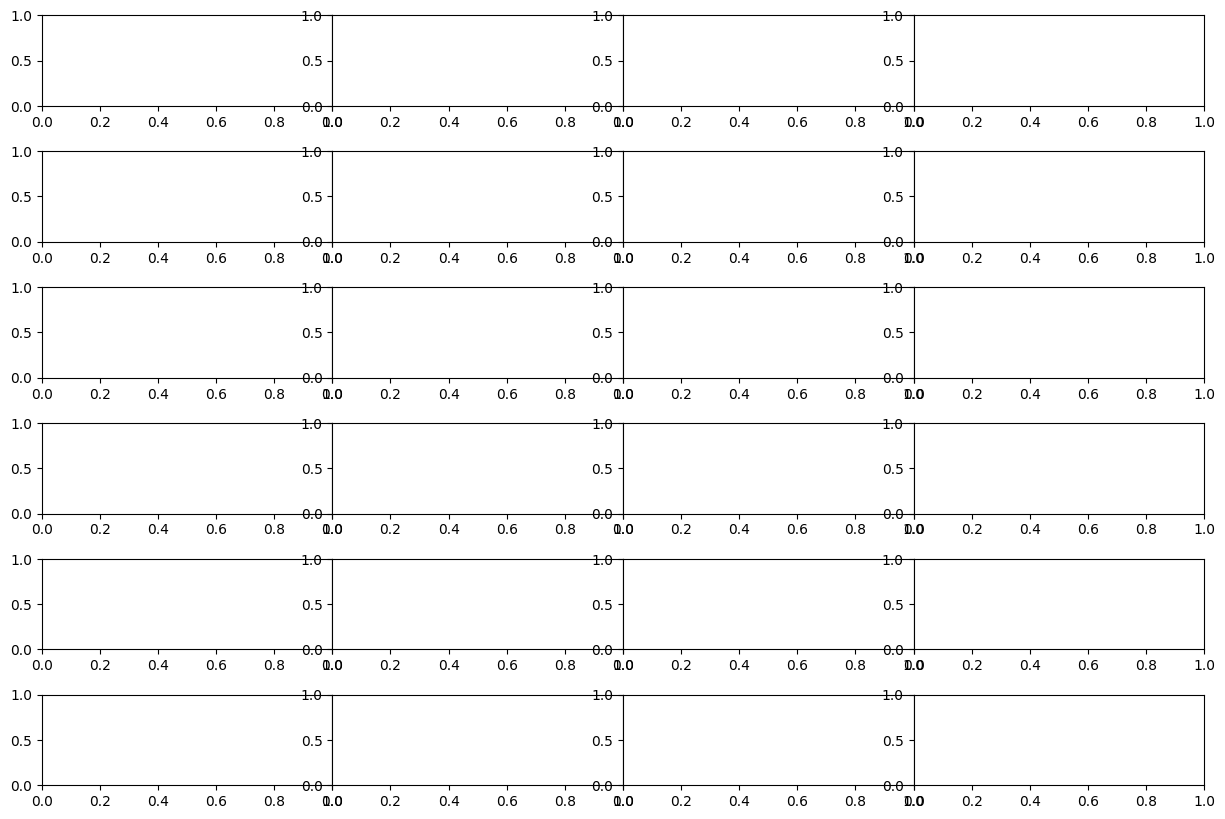

In [ ]:
img_displayer(testing_data_features, testing_data_labels, predicted_labels)

In [ ]:
test_loss, test_acc = cnn_model.evaluate(testing_data_features, testing_data_labels, verbose=2)
print(test_acc)

63/63 - 5s - loss: 1.3334 - accuracy: 0.6259 - 5s/epoch - 72ms/step
0.6258776187896729


In [ ]:
from sklearn.metrics import classification_report

predictions = cnn_model.predict(testing_data_features)

predicted_labels = np.argmax(predictions, axis=1)

class_report_dict = classification_report(testing_data_labels, predicted_labels, output_dict=True)

class_accuracies = {classes['Name'][int(class_label)]+f" ({int(class_label)}) ": (report['precision'],report['recall']) for class_label, report in class_report_dict.items() if class_label.isnumeric()}

sorted_precisions = sorted(class_accuracies.items(), key=lambda x: x[1][0], reverse=True)

for class_label, accuracy in sorted_precisions:
    print(f"Accuracy of Class {class_label}: {accuracy}")

sorted_recalls = sorted(class_accuracies.items(), key=lambda x: x[1][1], reverse=True)

for class_label, accuracy in sorted_recalls:
    print(f"Accuracy of Class {class_label}: {accuracy}")


63/63 [==============================] - 4s 50ms/step
Accuracy of Class Others (1) : (0.7287933094384708, 0.8221024258760108)
Accuracy of Class Unknown (2) : (0.08823529411764706, 0.039473684210526314)
Accuracy of Class Speed Limit (0) : (0.0873015873015873, 0.061452513966480445)
Accuracy of Class Others (1) : (0.7287933094384708, 0.8221024258760108)
Accuracy of Class Speed Limit (0) : (0.0873015873015873, 0.061452513966480445)
Accuracy of Class Unknown (2) : (0.08823529411764706, 0.039473684210526314)


In [ ]:
import os
from PIL import Image

class_names = classes['Name']

label_counts = {class_name: 0 for class_name in class_names}

for test_image_file in os.listdir(os.path.join(input_base_path, testing_folder)):
    label = int(convert_class_n(test_image_file[1:3]))
    class_name = classes['Name'][label]
    label_counts[class_name] += 1

for class_name, count in label_counts.items():
    print(f"Label {class_name}: Number of images corresponding: {count}")


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

63/63 [==============================] - 3s 40ms/step


c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

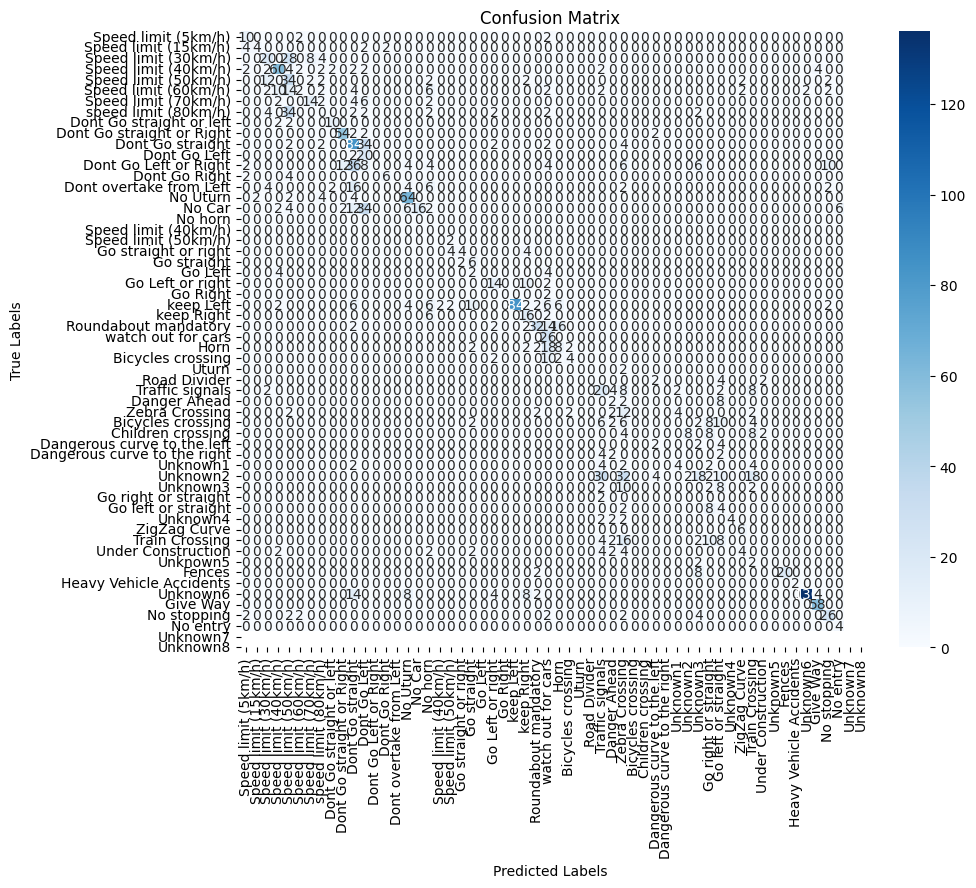

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = cnn_model.predict(testing_data_features)

predicted_labels = np.argmax(predictions, axis=1)

class_report_dict = classification_report(testing_data_labels, predicted_labels, output_dict=True)

class_accuracies = {classes['Name'][int(class_label)]: report['precision'] for class_label, report in class_report_dict.items() if class_label.isnumeric()}

sorted_accuracies = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)

conf_matrix = confusion_matrix(testing_data_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
